In [112]:
#Imports

In [168]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error, f1_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm, datasets
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Define project goal

Optimize the prediction of the count of bike rentals during given hours based on a variety of features 

## 1. Data exploration

In [169]:
# Read in data

In [209]:
df = pd.read_csv("../data/biketrain.csv", parse_dates=True)

In [210]:
dft = pd.read_csv("../data/biketest.csv", parse_dates=True)

In [211]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [212]:
df_train = df.copy()

In [213]:
#Reset index to datetime
df_train.set_index([pd.to_datetime(df['datetime'])], inplace = True)
df_train.drop(['datetime'], axis =1, inplace = True)

In [214]:
#Check for missing values
df_train.isnull().values.any()

False

In [215]:
#Inspect 'count' column
df_train['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

<AxesSubplot:>

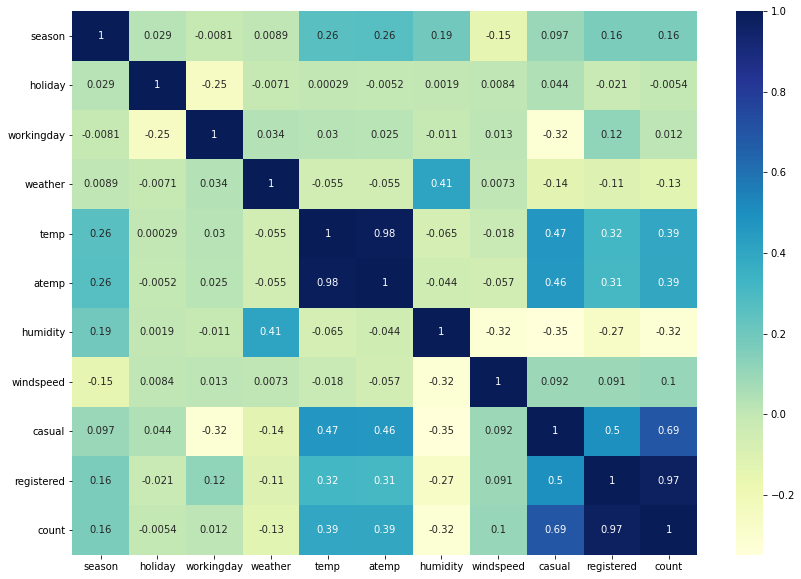

In [216]:
#Look at correlation matrix to get initial overview of features
plt.figure(figsize=(14,10))
sns.heatmap(df_train.corr(),
           cmap = 'YlGnBu',
           annot = True)

###### Observations:
    - Seasons seem to have less impact on bike rents than expected
    - temp has a slightly higher correlation with registered customers, therefore atemp is dropped
    
   

array([[<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>],
       [<AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>],
       [<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'casual'}>],
       [<AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>, <AxesSubplot:>]],
      dtype=object)

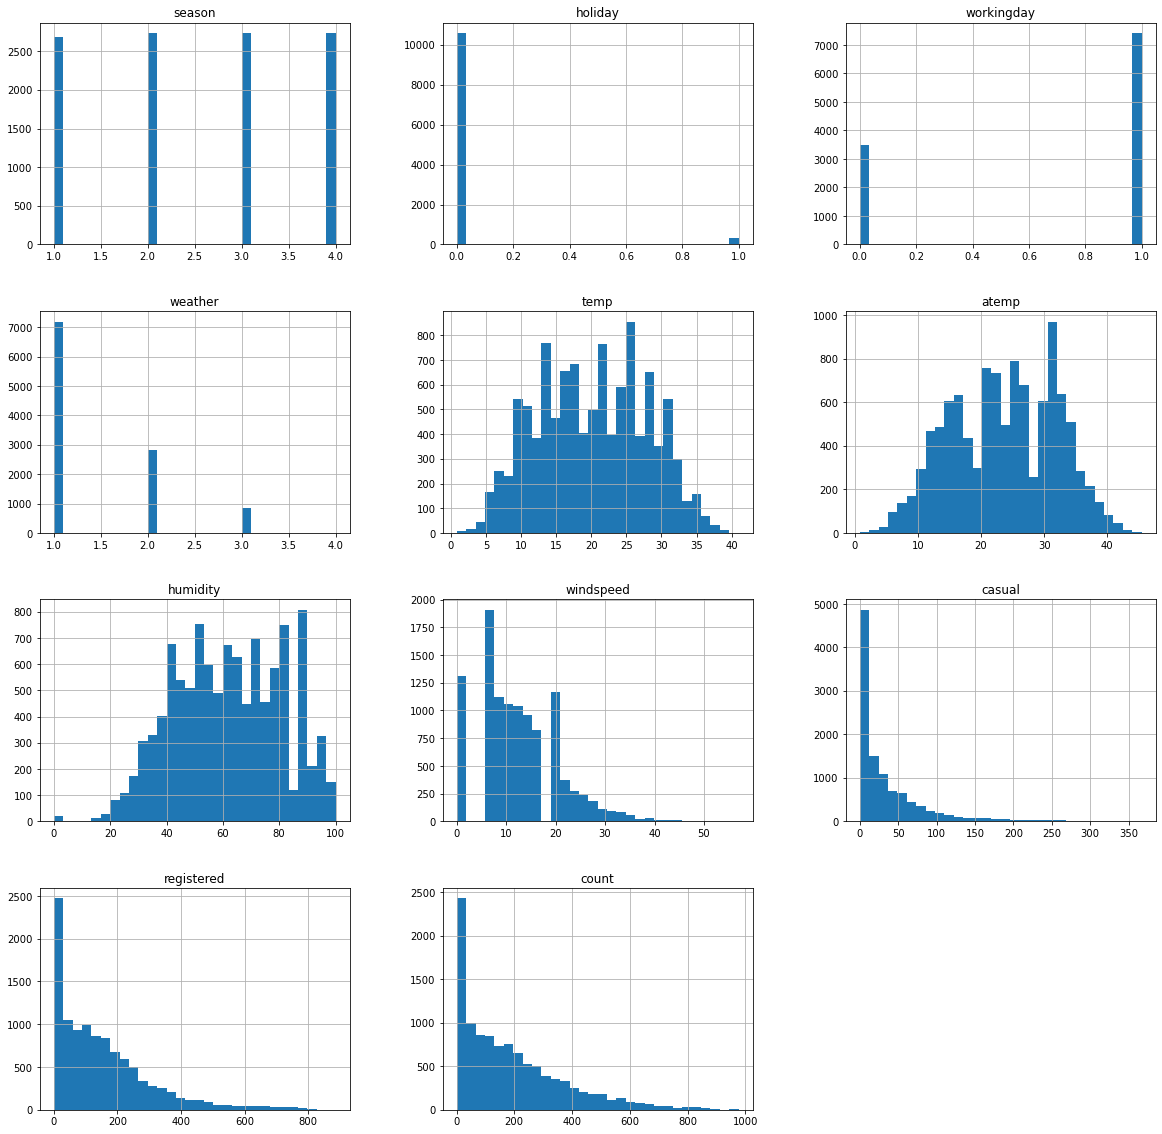

In [217]:
#Examine distributions (of interval features)
df_train.hist(bins=30,figsize=(20,20))

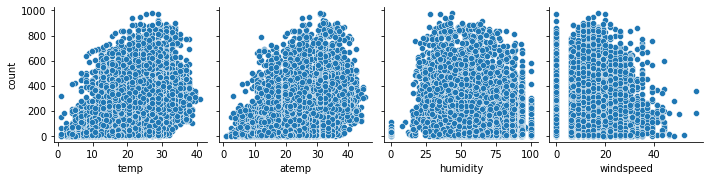

In [218]:
sns.pairplot(df_train, y_vars = ['count'], x_vars = df_train.columns[4:8])

<AxesSubplot:xlabel='datetime'>

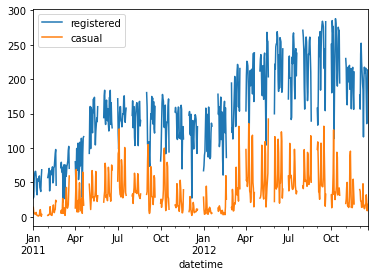

In [219]:
#Examine distinction between casual and registered customers
df_meanday = df_train.resample('1D').mean()
df_meanday.plot(y = ['registered', 'casual'])

% there might be seasonal differences between registered and casual customers

<AxesSubplot:xlabel='season'>

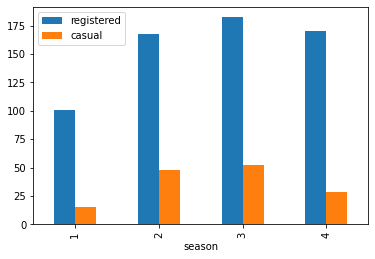

In [220]:
df_train.groupby(['season']).mean().plot.bar(y = ['registered', 'casual'])

<AxesSubplot:xlabel='atemp'>

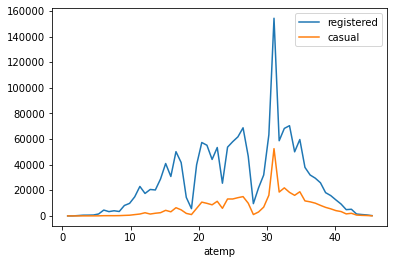

In [221]:
#Examine differrence between temp and atemp
df_train.groupby(['atemp']).sum().plot(y = ['registered', 'casual'])

<AxesSubplot:xlabel='temp'>

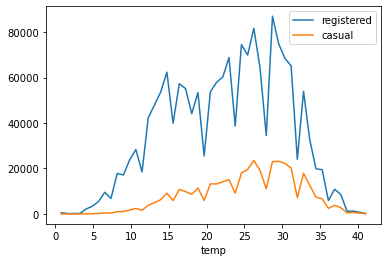

In [222]:
df_train.groupby(['temp']).sum().plot(y = ['registered', 'casual'])

<AxesSubplot:xlabel='holiday'>

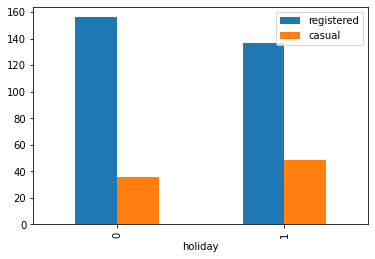

In [223]:
#Examine holiday behavior
df_train.groupby(['holiday']).mean().plot.bar(y = ['registered', 'casual'])

## 2. Base model

In [224]:
def linreg(features,y):
    """
    Creates linear regression with features given as a list. Since it is not a classification problem, Kaggle's metric "RMSLE" will be used
    """
    #Train/test split
    Xlin = df_train[features]
    ylin = df_train[y]
    ylog = np.log1p(ylin) #log+1 to optimize model against RMSLE used by Kaggle
 
    Xtrain, Xtest, ytrain, ytest = train_test_split(Xlin, ylog, random_state=69)
    lr = LinearRegression().fit(Xtrain, ytrain)
    ypredlog = lr.predict(Xlin)
    ypred = np.exp(ypredlog)-1 #to bring back predictions to original scale
    print("RMSLE score test:", np.sqrt(mean_squared_log_error(ylin, ypred)))
    
    #As train scores have been producing overflow errors and tend to be close to test scores for linear regression, they are not shown

In [225]:
features = ['temp','humidity','season','windspeed','weather','holiday','workingday']
linreg(features,'count')

RMSLE score test: 1.220541950978978


## 3. Feature engineering

In [226]:
#Add hours to create new features
df_train['hour']= df_train.index.hour

In [227]:
#   Differentiate between day and night and add this as a new one-hot encoded feature
df_train['daytime'] = np.where( ( (df_train['hour'] < 6 )| (df_train['hour'] >22) ), "Night", "Day")


In [228]:
#Bikes might be used for commuting therefore add 'commuting'-feature as True between 0600 and 0900 & 1700 and 1900 
df_train['commute'] = np.where( ( (df_train['hour'] > 5 )& (df_train['hour'] <10) ) |  ((df_train['hour'] > 16) & (df_train['hour'] <20)) ,1, 0)

In [229]:
#Initially seasons where divided by months of 1y, rearrange for meteorological seasons which also represent the warmest and coldest seasons
df_train['month']= df_train.index.month

conditions = [
    (df_train['month'] <3) | (df_train['month'] == 12),
    (df_train['month'] >2) & (df_train['month'] < 6),
    (df_train['month'] >5) & (df_train['month'] < 9),
    (df_train['month'] >8) & (df_train['month'] < 12)
]
choices = [1,2,3,4]

df_train['season_new']= np.select(conditions, choices)
features.remove('season')

In [230]:
#One-hot encoding 
df_train[['w1','w2','w3','w4']] = pd.get_dummies(df_train['weather'])
df_train[['s1','s2','s3','s4']] = pd.get_dummies(df_train['season_new'])
df_train[['Day','Night' ]] = pd.get_dummies(df_train['daytime'])

df_train.drop(columns = ["w4","s4","Day","month",'atemp','daytime'], inplace = True)

In [231]:
#add new features to features list
features.extend(['w1','w2','w3','s1','s2','s3','commute','Night'])
features.remove('weather')

In [232]:
features

['temp',
 'humidity',
 'windspeed',
 'holiday',
 'workingday',
 'w1',
 'w2',
 'w3',
 's1',
 's2',
 's3',
 'commute',
 'Night']

##### Scaling

In [233]:
# Use MinMax scaler for linear features
scaler = MinMaxScaler()

In [234]:
df_train["temp"] = scaler.fit_transform(df_train[["temp"]])
df_train["humidity"] = scaler.fit_transform(df_train[["humidity"]])
df_train["windspeed"] = scaler.fit_transform(df_train[["windspeed"]])

In [235]:
linreg(features,'count')

RMSLE score test: 0.8277304826795482


## 4. Feature expansion and regularization

In [236]:
#adding polynomias features
pl = PolynomialFeatures(degree=3, include_bias=True)
lr = LinearRegression()
pipeline = make_pipeline(pl,lr)

X1 = df_train[features]
y1 = df_train['count']
y1log = np.log1p(y1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1log, random_state=69)

pipeline.fit(Xtest,ytest)

ypred = pipeline.predict(X1)
ypred[ypred<0] = ypred[ypred>0].min() #used as intermediate shortcut for unusual but possible negative values
print("RMSLE score:", np.sqrt(mean_squared_log_error(y1, ypred)))

RMSLE score: 3.224703627520801


In [237]:
#ridge regression is used for regularization
pl = PolynomialFeatures(degree=3, include_bias=True)
r_ridge = Ridge(alpha=1, random_state=69)
pipeline = make_pipeline(pl,r_ridge)

X2 = df_train[features]
y2 = df_train['count']
y2log = np.log1p(y2)

Xtrain, Xtest, ytrain, ytest = train_test_split(X2, y2log, random_state=69)

pipeline.fit(Xtest,ytest)

ypred = pipeline.predict(X2)
ypred[ypred<0] = ypred[ypred>0].min() #used as intermediate shortcut for unusual but possible negative values
print("RMSLE score:", np.sqrt(mean_squared_log_error(y2, ypred)))

RMSLE score: 3.14306603809724


## 5. Random forest

In [238]:
# instantiate the model
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=30, 
                          random_state=69)
pipeline = make_pipeline(pl,rf)

Xrf = df_train[features]
yrf = df_train['count']
yrflog = np.log1p(yrf)
Xtrain, Xtest, ytrain, ytest = train_test_split(Xrf, yrflog, random_state=69)
pipeline.fit(Xtrain,ytrain)
ypred_prf = pipeline.predict(Xrf)
print("RMSLE score:", np.sqrt(mean_squared_log_error(yrf, ypred_prf)))

RMSLE score: 3.131380702820008


## 6. Hyperparameter optimization

In [44]:
def rmsle(y_true, y_pred, **kwargs):
    return mean_squared_log_error(y_true, y_pred, **kwargs)**0.5

In [45]:
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [46]:
clf = RandomForestRegressor(random_state = 69)
param_grid = {
    'max_depth': [5,10,15,30],
    'n_estimators': [50,100,250,500],
}
param_grid

{'max_depth': [5, 10, 15, 30], 'n_estimators': [50, 100, 250, 500]}

In [47]:
cv = GridSearchCV(clf, param_grid, 
                  return_train_score=True,
                  scoring=rmsle_scorer,#'neg_root_mean_squared_error'
                  cv=4, n_jobs=4, verbose = 1)

In [48]:
cv.fit(Xtrain, ytrain)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=69), n_jobs=4,
             param_grid={'max_depth': [5, 10, 15, 30],
                         'n_estimators': [50, 100, 250, 500]},
             return_train_score=True,
             scoring=make_scorer(rmsle, greater_is_better=False), verbose=1)

In [49]:
results = pd.DataFrame(cv.cv_results_)
column_names = results.columns.values
results.sort_values('mean_test_score',ascending=False)[column_names]

In [111]:
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.497808,0.020800,0.024534,0.004948,5,50,"{'max_depth': 5, 'n_estimators': 50}",-0.185324,-0.171125,-0.186522,-0.184508,-0.181870,0.006245,9,-0.175884,-0.179046,-0.175440,-0.175868,-0.176560,0.001447
1,0.917744,0.010010,0.033250,0.000433,5,100,"{'max_depth': 5, 'n_estimators': 100}",-0.185248,-0.170899,-0.186800,-0.184643,-0.181898,0.006398,12,-0.175814,-0.178934,-0.175484,-0.175775,-0.176502,0.001410
2,2.111694,0.006498,0.079749,0.002386,5,250,"{'max_depth': 5, 'n_estimators': 250}",-0.185279,-0.170545,-0.187175,-0.184676,-0.181919,0.006631,13,-0.175794,-0.178924,-0.175660,-0.175894,-0.176568,0.001363
3,4.343810,0.010983,0.151624,0.003700,5,500,"{'max_depth': 5, 'n_estimators': 500}",-0.185301,-0.170476,-0.187088,-0.184716,-0.181895,0.006651,11,-0.175728,-0.178855,-0.175663,-0.175902,-0.176537,0.001341
4,0.738615,0.003898,0.029250,0.001297,10,50,"{'max_depth': 10, 'n_estimators': 50}",-0.178490,-0.166820,-0.181777,-0.179603,-0.176672,0.005810,4,-0.132619,-0.135891,-0.132154,-0.134256,-0.133730,0.001472


## Prepare Xtest for Kaggle

In [85]:
df_test = dft.copy()

In [86]:
#Create datetime index
df_test.set_index([pd.to_datetime(df_test['datetime'])], inplace = True)
df_test.drop(['datetime'], axis =1, inplace = True)

In [87]:
#Feature engineering and feature expansion:
#   Add hours to create new features
df_test['hour']= df_test.index.hour
#   Differentiate between day and night and add this as a new one-hot encoded feature
df_test['daytime'] = np.where( ( (df_test['hour'] < 6 )| (df_test['hour'] >22) ), "Night", "Day")
#   Bikes might be used for commuting therefore add 'commuting'-feature as True between 0600 and 0900 & 1700 and 1900 
df_test['commute'] = np.where( ( (df_test['hour'] > 5 )& (df_test['hour'] <10) ) |  ((df_test['hour'] > 16) & (df_test['hour'] <20)) ,1, 0)
#   Rearrange seasons:
#   Initially seasons where divided by months of 1y, rearrange for meteorological seasons which also represent the warmest and coldest seasons
df_test['month']= df_test.index.month
conditions = [
    (df_test['month'] <3) | (df_test['month'] == 12),
    (df_test['month'] >2) & (df_test['month'] < 6),
    (df_test['month'] >5) & (df_test['month'] < 9),
    (df_test['month'] >8) & (df_test['month'] < 12)
]
choices = [1,2,3,4]

df_test['season_new']= np.select(conditions, choices)


In [88]:
#One-hot encoding of new seasonal and weather feature
df_test[['w1','w2','w3','w4']] = pd.get_dummies(df_test['weather'])
df_test[['s1','s2','s3','s4']] = pd.get_dummies(df_test['season_new'])
df_test[['Day','Night' ]] = pd.get_dummies(df_test['daytime'])
df_test.drop(columns = ["w4","s4","Day"], inplace = True)

In [89]:
# Use MinMax scaler for linear features
scaler = MinMaxScaler()
df_test["temp"] = scaler.fit_transform(df_test[["temp"]])
df_test["humidity"] = scaler.fit_transform(df_test[["humidity"]])
df_test["windspeed"] = scaler.fit_transform(df_test[["windspeed"]])

In [161]:
df_test.head(5)

,holiday,workingday,temp,humidity,windspeed,commute,w1,w2,w3,s1,s2,s3,Night
datetime,,,,,,,,,,,,,
2011-01-20 00:00:00,0,1,0.25,0.47619,0.464346,0,1,0,0,1,0,0,1
2011-01-20 01:00:00,0,1,0.25,0.47619,0.000000,0,1,0,0,1,0,0,1
2011-01-20 02:00:00,0,1,0.25,0.47619,0.000000,0,1,0,0,1,0,0,1
2011-01-20 03:00:00,0,1,0.25,0.47619,0.196458,0,1,0,0,1,0,0,1
2011-01-20 04:00:00,0,1,0.25,0.47619,0.196458,0,1,0,0,1,0,0,1


In [91]:
df_test.drop(columns=['weather','season','season_new','atemp','daytime','month','hour'],inplace = True)

In [104]:
Xtest = df_test

In [105]:
ykaggle = pipeline_rfo.predict(Xtest)

In [106]:
df_kaggle = df_test.copy()

In [107]:
df_kaggle['count'] = ykaggle

In [108]:
kaggle_output = df_kaggle['count']

In [162]:
kaggle_output.to_csv("KaggleSubmission.csv")

## Next steps:

After finding a linear regression model for this challenge the next step will be to feed this data into a neural network and see how the results differ.